---
#Libraries

In [ ]:
#%tensorflow_version 1.x
#!pip install tensorflow;

#%tensorflow_version 2.x
#!pip uninstall -y tensorflow
# !pip install tensorflow-gpu==1.14.0

# !pip install -q --upgrade ipython
# !pip install -q --upgrade ipykernel

In [ ]:
import numpy as np
import pandas as pd

import os
import ntpath
import pickle
from tqdm import tqdm
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

import cv2 as cv
from google.colab.patches import cv2_imshow

import keras #Nueral Netwrok Library
from keras import layers
from keras import Model
from keras.models import Sequential
from keras.utils import to_categorical, plot_model
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, LSTM, ZeroPadding3D, Input, TimeDistributed, Conv2D, Activation
from keras.optimizers import SGD
from keras.applications.vgg16 import VGG16

#Base Info

In [ ]:
classes = {'Diving':0, 'Jumping':1, 'Basketball':2, 'Tennis':3,  'Walking':4}
no_classes = len(classes)

base_directory = "/content/drive/My Drive/ActionRecognitionProject/"

---
---
#Read Data Paths

In [ ]:
train_path = base_directory + "Training_set"
test_path  = base_directory + "Testing_set"

In [ ]:
def read_train_data_paths():
    data_paths = []
    truth = []

    for class_name in classes:
        for file in tqdm(os.listdir(train_path + "/" + class_name)):
            vid_path = os.path.join(train_path + "/" + class_name, file)
            data_paths.append(vid_path)
            truth.append(classes[class_name])
    
    return data_paths, truth

In [ ]:
def read_test_data_paths():
    data_paths = []

    for file in tqdm(os.listdir(test_path)):
        vid_path = os.path.join(test_path, file)
        data_paths.append(vid_path)
    
    return data_paths

In [ ]:
def get_test_data_names():
    data_names = []
    for file in tqdm(os.listdir(test_path)):
        data_names.append(file)
    
    return data_names

#Know About Data Shape and Size

In [ ]:
def know_about_train_data(data_paths):
    vids_shape = []
    for vid_path in tqdm(data_paths):
        cap = cv.VideoCapture(vid_path)

        width = cap.get(cv.CAP_PROP_FRAME_WIDTH)
        height= cap.get(cv.CAP_PROP_FRAME_HEIGHT)
        depth = cap.get(cv.CAP_PROP_FRAME_COUNT)
        
        vids_shape.append((width, height, depth))

    print("\nWe have", len(vids_shape), " videos.")


    data_counter = {'Diving':0, 'Jumping':0, 'Basketball':0, 'Tennis':0,  'Walking':0}
    for class_name in classes:
            data_counter[class_name] = len(os.listdir(train_path + "/" + class_name))

    print("Videos are divided into ", data_counter)
    
    print("Videos Shapes are:")
    data_frame = pd.Series(vids_shape).value_counts()
    print(data_frame.head(len(data_frame)))

In [ ]:
def know_about_test_data(data_paths):
    vids_shape = []
    for vid_path in tqdm(data_paths):
        cap = cv.VideoCapture(vid_path)

        width = cap.get(cv.CAP_PROP_FRAME_WIDTH)
        height= cap.get(cv.CAP_PROP_FRAME_HEIGHT)
        depth = cap.get(cv.CAP_PROP_FRAME_COUNT)
        
        vids_shape.append((width, height, depth))
    
    print("\nWe have", len(vids_shape), " videos.")
    
    print("Videos Shapes are:")
    data_frame = pd.Series(vids_shape).value_counts()
    print(data_frame.head(len(data_frame)))

---
---
#Data Preprocessing

In [ ]:
D = 16   #New Depth size => Number of frames.
W = 112  #New Frame Width.
H = 112  #New Frame Height.
C = 3    #Number of channels.
sample_shape = (D, W, H, C) #Single Video shape.

In [ ]:
def preprocess(data_paths, data_truth):
    all_videos = []

    for i in tqdm(range(len(data_paths))):
        cap = cv.VideoCapture(data_paths[i])

        single_video_frames = []
        while (True):
            read_success, current_frame = cap.read()
            
            if not read_success:
                break

            current_frame = cv.resize(current_frame, (W, H))
            single_video_frames.append(current_frame)

        cap.release()

        single_video_frames = np.array(single_video_frames)
        single_video_frames.resize((D,W,H,C))

        all_videos.append(single_video_frames)
    
    all_videos = np.array(all_videos)
    data_truth = np.array(data_truth)

    return all_videos, data_truth

---
---
#Deep Learning Algorithms

In [ ]:
# Model configuration
model = None

CNN_type  = 0
LSTM_type = 1

weights_path = base_directory + "Weights/weights_C3D_sports1M_tf.h5"

In [ ]:
def create_model(model_type):
    global model
    if model_type == CNN_type:
        create_3D_CNN_model()
        compile_model()
        model.save(base_directory + "Models/CNN_3D_Model")
    else:
        create_LSTM_model()
        compile_model()
        model.save(base_directory + "Models/LSTM_Model")

In [ ]:
def compile_model():
    global model
    # Compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adam(lr=learning_rate),
                  metrics=['accuracy'])

In [ ]:
def load_model(model_type):
    global model
    if model_type == CNN_type:
        model = keras.models.load_model(base_directory + "Models/CNN_3D_Model")
    else:
        model = keras.models.load_model(base_directory + "Models/LSTM_Model")

---
##Algorithm 1: 3D CNN

In [ ]:
# Create the model
def create_3D_CNN_model():
    global model
    model = Sequential(name="3D-CNN Model")

    # 1st layer group
    model.add(Conv3D(64, (3, 3, 3), activation="relu",name="conv1", 
                        input_shape=(D, W, H, C),
                        strides=(1, 1, 1), padding="same"))  
    model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2), name="pool1", padding="valid"))

    # 2nd layer group  
    model.add(Conv3D(128, (3, 3, 3), activation="relu",name="conv2", 
                        strides=(1, 1, 1), padding="same"))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), name="pool2", padding="valid"))

    # 3rd layer group   
    model.add(Conv3D(256, (3, 3, 3), activation="relu",name="conv3a", 
                        strides=(1, 1, 1), padding="same"))
    model.add(Conv3D(256, (3, 3, 3), activation="relu",name="conv3b", 
                        strides=(1, 1, 1), padding="same"))	
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), name="pool3", padding="valid"))

    # 4th layer group  
    model.add(Conv3D(512, (3, 3, 3), activation="relu",name="conv4a", 
                        strides=(1, 1, 1), padding="same"))   
    model.add(Conv3D(512, (3, 3, 3), activation="relu",name="conv4b", 
                        strides=(1, 1, 1), padding="same"))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), name="pool4", padding="valid"))

    # 5th layer group  
    model.add(Conv3D(512, (3, 3, 3), activation="relu",name="conv5a", 
                        strides=(1, 1, 1), padding="same"))   
    model.add(Conv3D(512, (3, 3, 3), activation="relu",name="conv5b",
                        strides=(1, 1, 1), padding="same"))
    model.add(ZeroPadding3D(padding=(0, 1, 1)))	
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), name="pool5", padding="valid"))
    model.add(Flatten())
                        
    # FC layers group
    model.add(Dense(4096, activation='relu', name='fc6'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu', name='fc7'))
    model.add(Dropout(.5))
    model.add(Dense(487, activation='softmax', name='fc8'))


    if weights_path:
        model.load_weights(weights_path)

    #Make Changes for our model.
    model.layers.pop() #Remove last layer. as the number of classes used is not as same our data.
    pre_last_layer_output = model.layers[-1].output
    last_layer_output = Dense(no_classes, activation='softmax', name='fc9')(pre_last_layer_output)

    model = Model(model.input, last_layer_output)

    for layer in model.layers[:-5]:
        layer.trainable=False


---
##Algorithm 2: LSTM


In [ ]:
def build_vgg(shape):
    vgg = VGG16(weights="imagenet", input_shape=shape, include_top=False)
    
    return vgg

def create_LSTM_model():
    global model

    vggModel = build_vgg((W,H,C))
    for layer in vggModel.layers[:-1]:
        layer.trainable=False

    model = Sequential()
    input_layer = Input(shape=(D, W, H, C))
    model = TimeDistributed(vggModel)(input_layer) 
    model = TimeDistributed(Flatten())(model)
    
    model = LSTM(128, return_sequences=False)(model)
    model = Dropout(.5)(model)
    
    output_layer = Dense(no_classes, activation='softmax')(model)

    model = Model(input_layer, output_layer)

---
##Train

In [ ]:
batch_size = 50
no_epochs = 50
learning_rate = 0.0001
validation_split = 0.2
verbosity = 1

In [ ]:
def train(X_train, y_train, val_split):
    global model
    global validation_split
    validation_split = val_split
    
    # Convert target vectors to categorical targets
    y_train = to_categorical(y_train).astype(np.integer)
    
    # Fit data to model
    history = model.fit(X_train, y_train,
                batch_size=batch_size,
                epochs=no_epochs,
                verbose=verbosity,
                validation_split=val_split)

---
##Test

In [ ]:
def test(X_test, y_test):
    # Convert target vectors to categorical targets
    y_test = to_categorical(y_test).astype(np.integer)
    
    # Generate generalization metrics
    model_loss, model_accuracy = model.evaluate(X_test, y_test, verbose=0)
    y_pred = model.predict(X_test)

    return model_loss, model_accuracy, y_pred

In [ ]:
def predict(X_test):
        y_pred = model.predict(X_test)
        return y_pred

---
---
#Helper Functions

In [ ]:
def save_structure(structure, name):
    with open(base_directory + 'Structures/' + name + '.pickle', 'wb') as handle:
        pickle.dump(structure, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_structure(name):
    if os.path.isfile(base_directory + 'Structures/' + name + '.pickle'):
        with open(base_directory + 'Structures/' + name + '.pickle', 'rb') as handle:
            structure = pickle.load(handle)
        return structure
    else:
        return []

In [ ]:
def get_class(value):
    value = get_value(value)
    for class_name in classes:
        if classes[class_name] == value:
            return class_name

In [ ]:
def shuffle(X_data, y_data):
    X_data_series = pd.Series(X_data)
    y_data_series = pd.Series(y_data)

    dataFrame = pd.DataFrame()
    dataFrame = pd.concat([X_data_series, y_data_series], axis=1)

    dataArray = np.array(dataFrame)
    np.random.shuffle(dataArray)
    
    return dataArray[:,0], dataArray[:,1]

In [ ]:
#A value is either equal to a 'label index' of a 'categorical list' that indicates which label.
#ex:
#if value = 2 or value = [0, 0, 1, 0, 0]:
#return 2
def get_value(value):
    if type(value) == type([]) or type(value) == type(np.array([])):
        return np.argmax(value)
    return value

In [ ]:
def create_predictions_csv_file(model_name, predictions):
    pred = []

    data_names = get_test_data_names()
    for i in range(len(predictions)):
        pred.append([data_names[i], get_value(predictions[i])])

    np_predictions = np.array(pred)
    np.savetxt(fname=model_name + "_predictions.csv", X=np_predictions, delimiter=",", fmt='%s')


---
---
#Visualization

In [ ]:
def have_a_look(X_data, y_data):
    plt.figure(figsize=(20, 20))
    for n , i in enumerate(list(np.random.randint(0,len(X_data),36))): #Pick random 36 videos
        plt.subplot(6,6,n+1)
        plt.axis('off')

        label = y_data[i] #ex-> label = [0.2, 0.3, 0.2, 0.8, 0.6]
        plt.title(get_class(get_value(label))) #The highest value is 0.8 which is at class no. 4

        first_frame = X_data[i][0] #Pick first frame of this video.
        if C == 1:
            first_frame = first_frame.reshape((W,H))
        plt.imshow(first_frame)   

In [ ]:
def plot_model_metrics(history):
    plt.figure(figsize=(8, 4))
    plt.title('Model Performance for Video Action Detection', size=18, c="C7")
    plt.ylabel('Loss value', size=15, color='C7')
    plt.xlabel('Epoch No.', size=15, color='C7')
    #plt.plot(history.history['loss'],  'o-', label='Training Data Loss', linewidth=2, c='C3') #C3 = red color.
    plt.plot(history.history['accuracy'],  'o-', label='Training Data Accuracy', linewidth=2, c='C2') #C2 = green color.

    if len(history.history) > 2:
        plt.plot(history.history['val_accuracy'],  'o-', label='Validation Data Accuracy', linewidth=2, c='b') #b = blue color.

    plt.legend()    
    plt.show()

In [ ]:
def show_model_performance():
    global model
    plot_model_metrics(model.history)


In [ ]:
def show_summary():
    global model
    print(model.summary())

In [ ]:
def save_model_plot(name):
    global model
    plot_model(model, to_file=name+'.png', show_shapes = True)

---
---
#Run

**Check whether to load the models and sturctures that are already saved**

In [ ]:
load_tracker = {"CNN_3D_Model":"n",
                "LSTM_Model":"n",
                "train_data":"n",
                "test_data":"n",
                }

for file_name in load_tracker:
    user_input = input("Load " + file_name + " y/n? ")
    load_tracker[file_name] = user_input

print('\n', load_tracker)

Load CNN_3D_Model y/n? n
Load LSTM_Model y/n? n
Load train_data y/n? n
Load test_data y/n? n

 {'CNN_3D_Model': 'n', 'LSTM_Model': 'n', 'train_data': 'n', 'test_data': 'n'}


---
**Which model to run?**

In [ ]:
model_id = int(input("Which model to run? '0' for 3D_CNN and '1' for LSTM? "))

model_name = 'CNN_3D_Model'

if model_id == 1:
    model_name = "LSTM_Model"

print('\nChosen Model: ' + model_name)

Which model to run? '0' for 3D_CNN and '1' for LSTM? 0

Chosen Model: CNN_3D_Model


---
**Reading Data Paths and shuffle them to have the best of the learning process.**

In [ ]:
if load_tracker["train_data"] == "n":
    print("Reading Training Data..")
    trainingData_paths, y_train = read_train_data_paths()
    trainingData_paths, y_train = shuffle(trainingData_paths, y_train)

100%|██████████| 67/67 [00:00<00:00, 205723.55it/s]

Reading Training Data..


---
**We should know more about the size and the shapes of our train data.**

In [ ]:
if load_tracker["train_data"] == "n":
    know_about_train_data(trainingData_paths)

100%|██████████| 474/474 [00:01<00:00, 339.71it/s]


We have 474  videos.
Videos are divided into  {'Diving': 113, 'Jumping': 100, 'Basketball': 89, 'Tennis': 105, 'Walking': 67}
Videos Shapes are:
(320.0, 240.0, 239.0)    44
(320.0, 240.0, 201.0)    32
(320.0, 240.0, 151.0)    15
(320.0, 240.0, 238.0)    12
(320.0, 240.0, 105.0)     9
                         ..
(320.0, 240.0, 88.0)      1
(320.0, 240.0, 401.0)     1
(320.0, 256.0, 149.0)     1
(320.0, 240.0, 117.0)     1
(320.0, 240.0, 71.0)      1
Length: 192, dtype: int64


---
**Reading Test Data**

In [ ]:
if load_tracker["test_data"] == "n":
    print("Reading Testing Data..")
    testingData_paths = read_test_data_paths()

100%|██████████| 126/126 [00:00<00:00, 199502.57it/s]

Reading Testing Data..


---
**Then also know about the size and the shapes of our train data.**

In [ ]:
if load_tracker["test_data"] == "n":
    know_about_test_data(testingData_paths)

100%|██████████| 126/126 [00:00<00:00, 355.99it/s]


We have 126  videos.
Videos Shapes are:
(320.0, 240.0, 239.0)    11
(320.0, 240.0, 179.0)     4
(320.0, 240.0, 101.0)     4
(320.0, 240.0, 119.0)     4
(320.0, 240.0, 115.0)     3
                         ..
(320.0, 214.0, 177.0)     1
(320.0, 240.0, 176.0)     1
(320.0, 240.0, 201.0)     1
(320.0, 240.0, 130.0)     1
(320.0, 240.0, 87.0)      1
Length: 85, dtype: int64


---
**Train Data Preprocessing**

In [ ]:
if load_tracker["train_data"] == "n":
    X_train, y_train = preprocess(trainingData_paths, y_train)
    save_structure(X_train, "X_train")
    save_structure(y_train, "y_train")
else:
    X_train = load_structure("X_train")
    y_train = load_structure("y_train")
    print("Training data is Loaded!")

100%|██████████| 474/474 [00:38<00:00, 12.30it/s]


---
**Have a look on the first frame of a 36 random samples of train data**

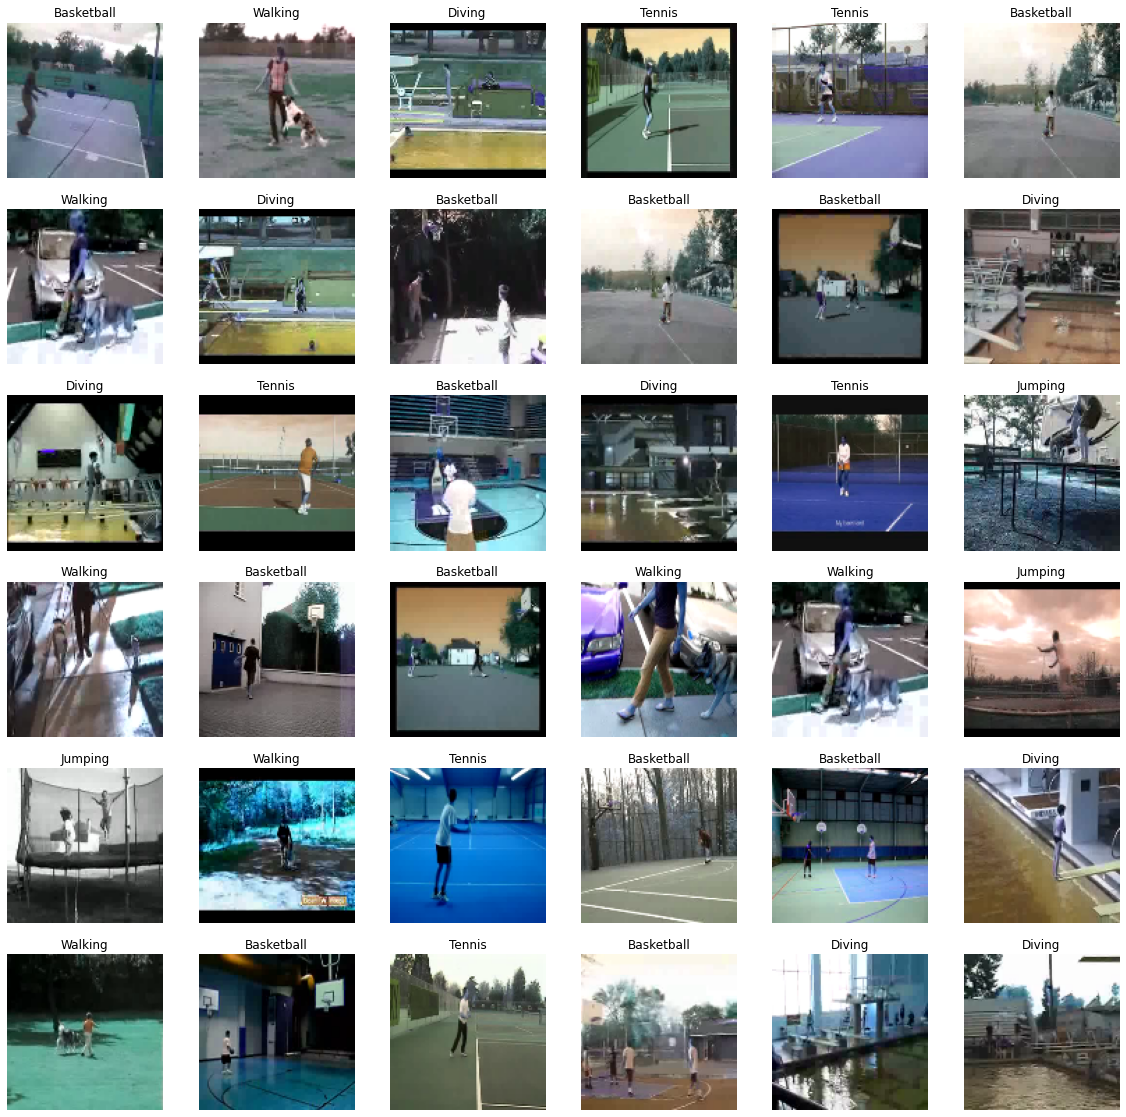

In [ ]:
have_a_look(X_train, y_train)

---
**Test Data Preprocessing**

In [ ]:
if load_tracker["test_data"] == "n":
    X_test, _ = preprocess(testingData_paths, [])
    save_structure(X_test, "X_test")
else:
    X_test = load_structure("X_test")
    print("Testing data is Loaded")


100%|██████████| 126/126 [00:09<00:00, 12.82it/s]


---
**Create/Load Model and Show it's Structure**

In [ ]:
if load_tracker[model_name] == "n":
    create_model(model_id)
    save_model_plot(model_name)
    print("Model is created!")
else:
    load_model(model_id)
    print("Model is loaded!")

show_summary()

INFO:tensorflow:Assets written to: /content/drive/My Drive/ActionRecognitionProject/Models/CNN_3D_Model/assets
Model is created!
Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_input (InputLayer)     [(None, 16, 112, 112, 3)] 0         
_________________________________________________________________
conv1 (Conv3D)               (None, 16, 112, 112, 64)  5248      
_________________________________________________________________
pool1 (MaxPooling3D)         (None, 16, 56, 56, 64)    0         
_________________________________________________________________
conv2 (Conv3D)               (None, 16, 56, 56, 128)   221312    
_________________________________________________________________
pool2 (MaxPooling3D)         (None, 8, 28, 28, 128)    0         
_________________________________________________________________
conv3a (Conv3D)              (None, 8, 28, 28, 256)    8

---
**Now start training the model.**

In [ ]:
train(X_train, y_train, val_split=0.2)

Epoch 1/50
8/8 [==============================] - 6s 811ms/step - loss: 1.5939 - accuracy: 0.2427 - val_loss: 1.5797 - val_accuracy: 0.2947
Epoch 2/50
8/8 [==============================] - 4s 498ms/step - loss: 1.5705 - accuracy: 0.4327 - val_loss: 1.5634 - val_accuracy: 0.4632
Epoch 3/50
8/8 [==============================] - 4s 497ms/step - loss: 1.5574 - accuracy: 0.5330 - val_loss: 1.5572 - val_accuracy: 0.4526
Epoch 4/50
8/8 [==============================] - 4s 498ms/step - loss: 1.5529 - accuracy: 0.5172 - val_loss: 1.5535 - val_accuracy: 0.4632
Epoch 5/50
8/8 [==============================] - 4s 498ms/step - loss: 1.5500 - accuracy: 0.5303 - val_loss: 1.5490 - val_accuracy: 0.4947
Epoch 6/50
8/8 [==============================] - 4s 495ms/step - loss: 1.5460 - accuracy: 0.5488 - val_loss: 1.5453 - val_accuracy: 0.5263
Epoch 7/50
8/8 [==============================] - 4s 497ms/step - loss: 1.5424 - accuracy: 0.5726 - val_loss: 1.5432 - val_accuracy: 0.5474
Epoch 8/50
8/8 [====

As shown in the graph, the curve of 'loss' keeps declining and the curve of 'accuracy' keeps inclining which means no over fitting is taking place.

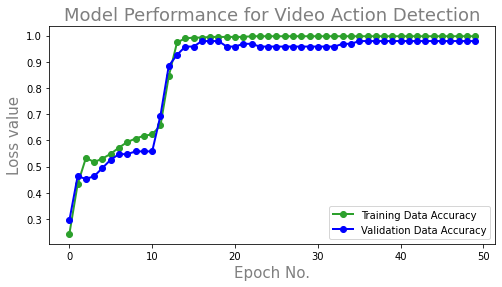

In [ ]:
show_model_performance()

---
**So far,** we have an acceptable accuracy on the 'training dat'a and the 'validation data'. Now we 
should train our model on all our data in order to get the best accuracy output on our 'testing data'.

In [ ]:
train(X_train, y_train, val_split=0)

Epoch 1/50
10/10 [==============================] - 5s 475ms/step - loss: 1.4483 - accuracy: 0.9916
Epoch 2/50
10/10 [==============================] - 4s 397ms/step - loss: 1.4458 - accuracy: 0.9937
Epoch 3/50
10/10 [==============================] - 4s 398ms/step - loss: 1.4445 - accuracy: 0.9916
Epoch 4/50
10/10 [==============================] - 4s 399ms/step - loss: 1.4430 - accuracy: 0.9916
Epoch 5/50
10/10 [==============================] - 4s 399ms/step - loss: 1.4408 - accuracy: 0.9937
Epoch 6/50
10/10 [==============================] - 4s 399ms/step - loss: 1.4388 - accuracy: 0.9958
Epoch 7/50
10/10 [==============================] - 4s 398ms/step - loss: 1.4369 - accuracy: 0.9979
Epoch 8/50
10/10 [==============================] - 4s 399ms/step - loss: 1.4354 - accuracy: 0.9979
Epoch 9/50
10/10 [==============================] - 4s 398ms/step - loss: 1.4337 - accuracy: 0.9979
Epoch 10/50
10/10 [==============================] - 4s 398ms/step - loss: 1.4321 - accuracy: 0.9979

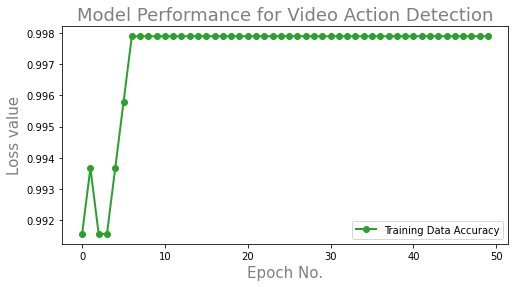

In [ ]:
show_model_performance()

---
**Test**

In [ ]:
y_predict = predict(X_test)

---
**Have a look on the first frame of a 36 random samples of test data**

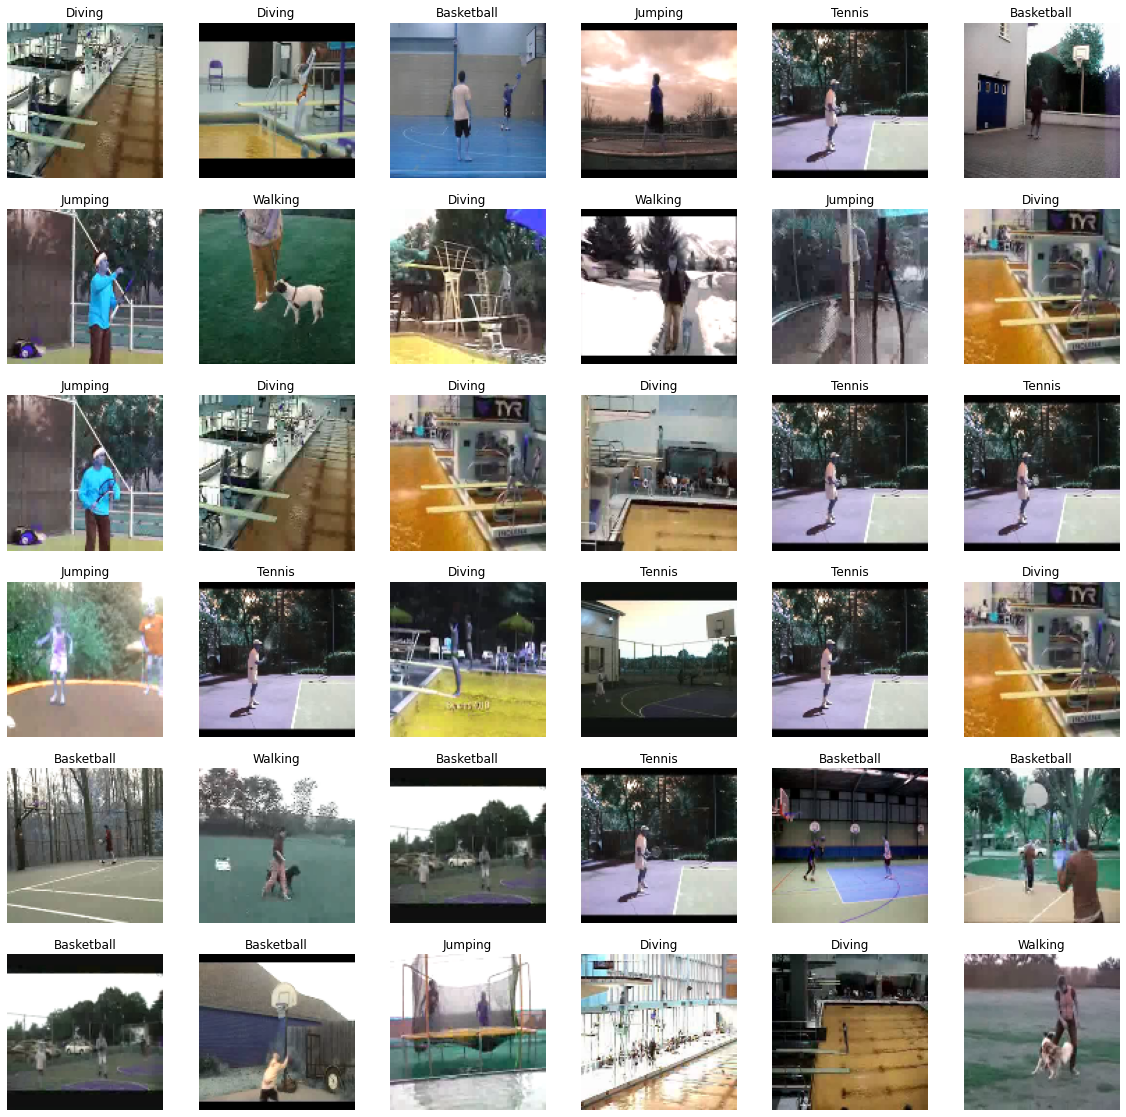

In [ ]:
have_a_look(X_test, y_predict)

In [ ]:
create_predictions_csv_file(model_name, y_predict)

100%|██████████| 126/126 [00:00<00:00, 453632.88it/s]
